In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import cv2
from time import time

import tensorflow as tf
# tf.enable_eager_execution()
tf.VERSION

'1.13.1'

### Get data: train/val paths/labels

('Train data : ', 40000, 40000, 9, 0)
(['../data/cifar10/21931_8.jpg', '../data/cifar10/14051_4.jpg', '../data/cifar10/16503_4.jpg'], [8, 4, 4])


('Validation data : ', 10000, 10000, 9, 0)
(['../data/cifar10/30143_6.jpg', '../data/cifar10/48240_5.jpg', '../data/cifar10/36076_9.jpg'], [6, 5, 9])


(32, 32, 3)


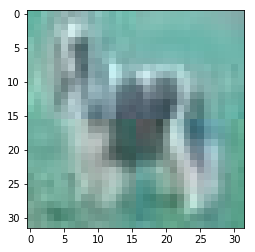

In [2]:
import numpy as np

src_dir = '../data/cifar10/'
img_paths = glob(src_dir + '*.jpg')
N = len(img_paths)

idx = np.arange(N)
np.random.shuffle(idx)
num_train = int(0.8*N)
train_paths = [img_paths[idx[i]] for i in range(num_train)]
val_paths = [img_paths[idx[num_train + i]] for i in range(N - num_train)]

train_labels = []
for path in train_paths:
    name = os.path.basename(path)
    train_labels.append(int(name[name.find('_')+1:-4]))
print('Train data : ', len(train_paths), len(train_labels), max(train_labels), min(train_labels))
print(train_paths[:3], train_labels[:3])
print('\n')


val_labels = []
for path in val_paths:
    name = os.path.basename(path)
    val_labels.append(int(name[name.find('_')+1:-4]))
print('Validation data : ', len(val_paths), len(val_labels), max(val_labels), min(val_labels))
print(val_paths[:3], val_labels[:3])
print('\n')

# Display an image
img = cv2.imread(val_paths[1])
print(img.shape)
plt.imshow(img)
plt.show()

### Data generators


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
((32, 32, 32, 3), (32,))
((32, 32, 32, 3), (32,))


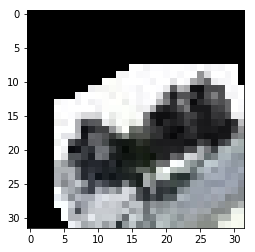

In [3]:
# Preprocess data
def parse_fn(path, label):
    img = tf.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize_images(img, [32, 32])
    img = img/255.0
    return img, label

# Augment data (translate and rotate)
def augment_fn(img, label):
    img_tx = tf.contrib.image.rotate(img, \
            angles = tf.random_uniform(shape=[], minval=-10, maxval=10))
    img_tx = tf.contrib.image.translate(img_tx, \
            translations = [tf.random_uniform(shape=[], minval=-10, maxval=10), \
                           tf.random_uniform(shape=[], minval=-10, maxval=10)])
    return img_tx, label

# Train Data
train_data = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(buffer_size=len(train_paths))
    .map(parse_fn, num_parallel_calls = 4)
    .map(augment_fn, num_parallel_calls = 4)
    .batch(32)
    .prefetch(1)
)
train_iter = train_data.make_initializable_iterator()
train_next = train_iter.get_next()

# Validation data
val_data = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(parse_fn, num_parallel_calls = 4)
    .batch(32)
    .prefetch(1)
)
val_iter = val_data.make_initializable_iterator()
val_next = val_iter.get_next()

# Verify iterators
num_epochs = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())        
    
    sess.run(train_iter.initializer)
    x_train, y_train = sess.run(train_next)
    print(x_train.shape, y_train.shape)
    
    sess.run(val_iter.initializer)
    x_val, y_val = sess.run(val_iter.get_next())
    print(x_val.shape, y_val.shape)
    
img = x_train[0]
plt.imshow(img)
plt.show()

# Model

In [4]:
import tensorflow.keras as K
import tensorflow.keras.layers as layers

def conv2d_block(x, filters, kernel_size = (3,3), \
        padding='same', activation = 'relu', \
        batchnorm=True, pool = True, dropout = 0.25, name=None):
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, \
            padding=padding, activation=activation, name=name+'_conv')(x)
    x = layers.BatchNormalization(name=name+'_bn')(x) if batchnorm else x
    x = layers.MaxPool2D(2, 2, name=name+'_pool')(x) if pool else x
    x = layers.Dropout(rate = dropout, name=name+'_dp')(x)
    return x

def fc_block(x, units, activation = 'relu', dropout=0.25, name=None):
    x = layers.Dense(units, activation, name=name+'_dense')(x)
    x = layers.Dropout(rate = dropout, name=name+'_dp')(x)
    return x

def smallCNN(x, num_classes=10):
    x = conv2d_block(x, 32, pool=False, dropout=0, name='conv_block1')
    x = conv2d_block(x, 32, pool=True, dropout=0.25, name='conv_block2')
    x = conv2d_block(x, 64, pool=False, dropout=0, name='conv_block3')
    x = conv2d_block(x, 64, pool=True, dropout=0.25, name='conv_block4')
    x = layers.Flatten(name='flat')(x)
    x = fc_block(x, 512, dropout=0.5, name='fc1')
    x = fc_block(x, num_classes, 'linear', name='fc2')
    return x

### Train the model

In [11]:
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
y_pred = smallCNN(x)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# summ_hist = tf.summary.histogram('Weight hist', tf.get_variable('conv2d/kernel:0'))
wt = [v for v in tf.global_variables() if v.name == "conv_block1_conv/kernel:0"][0]
summ_hist = tf.summary.histogram('Weight_hist', wt)

num_epochs = 1
with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    a = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    wt1 = [v for v in tf.global_variables() if v.name == "conv_block1_conv/kernel:0"][0]    
    print(wt1.shape)
    
#     print(len(a))
#     for i in range(len(a)):
#         print(a[i])
    
#     for epoch in range(num_epochs):
#         sess.run(train_iter.initializer)
#         while True:
#             try:
#                 x_batch, y_batch = sess.run(train_next)
#                 _, loss_val, summ = sess.run([optimizer, loss, summ_hist], feed_dict={x:x_batch, y:y_batch})                
#                 writer.add_summary(summ)
#                 print(loss_val)
#                 break
#             except tf.errors.OutOfRangeError:
#                 break
            
        